# Purpose
- Purpose of this notebook is to;
    - Create multiple features to model trend, seasonality, ciclicality, and other exogenous features.
    - Once features have been created, use Mutal Information (MI) and other heuristics to determine the appropriate and best features
    - Note: Since the lead time for our predictions is 14 days, some features such as lag 1 may not be applicable for some models. The purpose of this feature engineering exercise is to use all possible features, and then trim down features that may not be useful, or may not be applicable
    - Once the best features have been determined, this information will be used to build sklearn pipelines 

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import display
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.feature_selection import mutual_info_regression

from src import plot

# Import Pre-processed Data

In [2]:
# import csv data into pandas dataframe
df_train = pd.read_csv('data/preprocessed/train_preprocessed.csv')
df_test = pd.read_csv('data/preprocessed/test_preprocessed.csv')
df_holidays = pd.read_csv('data/preprocessed/holidays_preprocessed.csv')
df_stores = pd.read_csv('data/preprocessed/stores_preprocessed.csv')
df_oil = pd.read_csv('data/preprocessed/oil_preprocessed.csv')
df_transactions = pd.read_csv('data/preprocessed/transactions_preprocessed.csv')

In [3]:
# combine store_nbr & family into one column in df_train
df_train['store_family'] = df_train['store_nbr'].astype(str) + '_' + df_train['family']
df_test['store_family'] = df_test['store_nbr'].astype(str) + '_' + df_test['family']

In [4]:
print(f'{df_train.shape=}')
display(df_train.head())
print(f'{df_test.shape=}')
display(df_test.head())
print(f'{df_holidays.shape=}')
display(df_holidays.head())
print(f'{df_oil.shape=}')
display(df_oil.head())
print(f'{df_stores.shape=}')
display(df_stores.head())
print(f'{df_transactions.shape=}')
display(df_transactions.head())

df_train.shape=(3008016, 6)


,family,store_nbr,date,sales,onpromotion,store_family
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE


df_test.shape=(28512, 6)


,id,date,store_nbr,family,onpromotion,store_family
0,3000888,2017-08-16,1,AUTOMOTIVE,0,1_AUTOMOTIVE
1,3000889,2017-08-16,1,BABY CARE,0,1_BABY CARE
2,3000890,2017-08-16,1,BEAUTY,2,1_BEAUTY
3,3000891,2017-08-16,1,BEVERAGES,20,1_BEVERAGES
4,3000892,2017-08-16,1,BOOKS,0,1_BOOKS


df_holidays.shape=(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


df_oil.shape=(1704, 2)


,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


df_stores.shape=(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


df_transactions.shape=(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [5]:
# add date time features
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['dayofweek'] = df_test['date'].dt.dayofweek
df_test['weekofyear'] = df_test['date'].dt.weekofyear
df_test['quarter'] = df_test['date'].dt.quarter

df_test['weekend'] = df_test['dayofweek'].isin([5,6])
df_test['payday'] = df_test['day'].isin([15]) | df_test['date'].dt.is_month_end

df_test

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_8586/2972150486.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_test['weekofyear'] = df_test['date'].dt.weekofyear


,id,date,store_nbr,family,onpromotion,store_family,year,month,day,dayofweek,weekofyear,quarter,weekend,payday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,1_AUTOMOTIVE,2017,8,16,2,33,3,False,False
1,3000889,2017-08-16,1,BABY CARE,0,1_BABY CARE,2017,8,16,2,33,3,False,False
2,3000890,2017-08-16,1,BEAUTY,2,1_BEAUTY,2017,8,16,2,33,3,False,False
3,3000891,2017-08-16,1,BEVERAGES,20,1_BEVERAGES,2017,8,16,2,33,3,False,False
4,3000892,2017-08-16,1,BOOKS,0,1_BOOKS,2017,8,16,2,33,3,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,9_POULTRY,2017,8,31,3,35,3,False,True
28508,3029396,2017-08-31,9,PREPARED FOODS,0,9_PREPARED FOODS,2017,8,31,3,35,3,False,True
28509,3029397,2017-08-31,9,PRODUCE,1,9_PRODUCE,2017,8,31,3,35,3,False,True
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,9_SCHOOL AND OFFICE SUPPLIES,2017,8,31,3,35,3,False,True


# Create Features 
- Create multiple features to model trend, seasonality, ciclicality, holidays, etc.
- Once features have been created, use Mutal Information (MI) and other heuristics to determine the appropriate and best features
- Note: Since the lead time for our predictions is 14 days, some features such as lag 1 may not be applicable for some models. The purpose of this feature engineering exercise is to use all possible features, and then trim down features that may not be useful, or may not be applicable

- **Trend Features**
    - Assume there is an increasing linear trend

In [6]:
df_train['trend'] = df_train.groupby(['store_family']).cumcount()

- **Seasonality Features**

In [7]:
# add date time features
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['dayofweek'] = df_train['date'].dt.dayofweek
df_train['weekofyear'] = df_train['date'].dt.weekofyear
df_train['quarter'] = df_train['date'].dt.quarter

df_train['weekend'] = df_train['dayofweek'].isin([5,6])
df_train['payday'] = df_train['day'].isin([15]) | df_train['date'].dt.is_month_end

df_train

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_8586/310910962.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_train['weekofyear'] = df_train['date'].dt.weekofyear


,family,store_nbr,date,sales,onpromotion,store_family,trend,year,month,day,dayofweek,weekofyear,quarter,weekend,payday
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE,0,2013,1,1,1,1,1,False,False
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE,1,2013,1,2,2,1,1,False,False
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE,2,2013,1,3,3,1,1,False,False
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE,3,2013,1,4,4,1,1,False,False
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE,4,2013,1,5,5,1,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,SEAFOOD,54,2017-08-11,0.0,0,54_SEAFOOD,1683,2017,8,11,4,32,3,False,False
3008012,SEAFOOD,54,2017-08-12,1.0,1,54_SEAFOOD,1684,2017,8,12,5,32,3,True,False
3008013,SEAFOOD,54,2017-08-13,2.0,0,54_SEAFOOD,1685,2017,8,13,6,32,3,True,False
3008014,SEAFOOD,54,2017-08-14,0.0,0,54_SEAFOOD,1686,2017,8,14,0,33,3,False,False


- Use periodogram to determine Fourier Features

/Users/ani/Projects/2_retail_store_sales_forecasting/src/plot.py:149: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


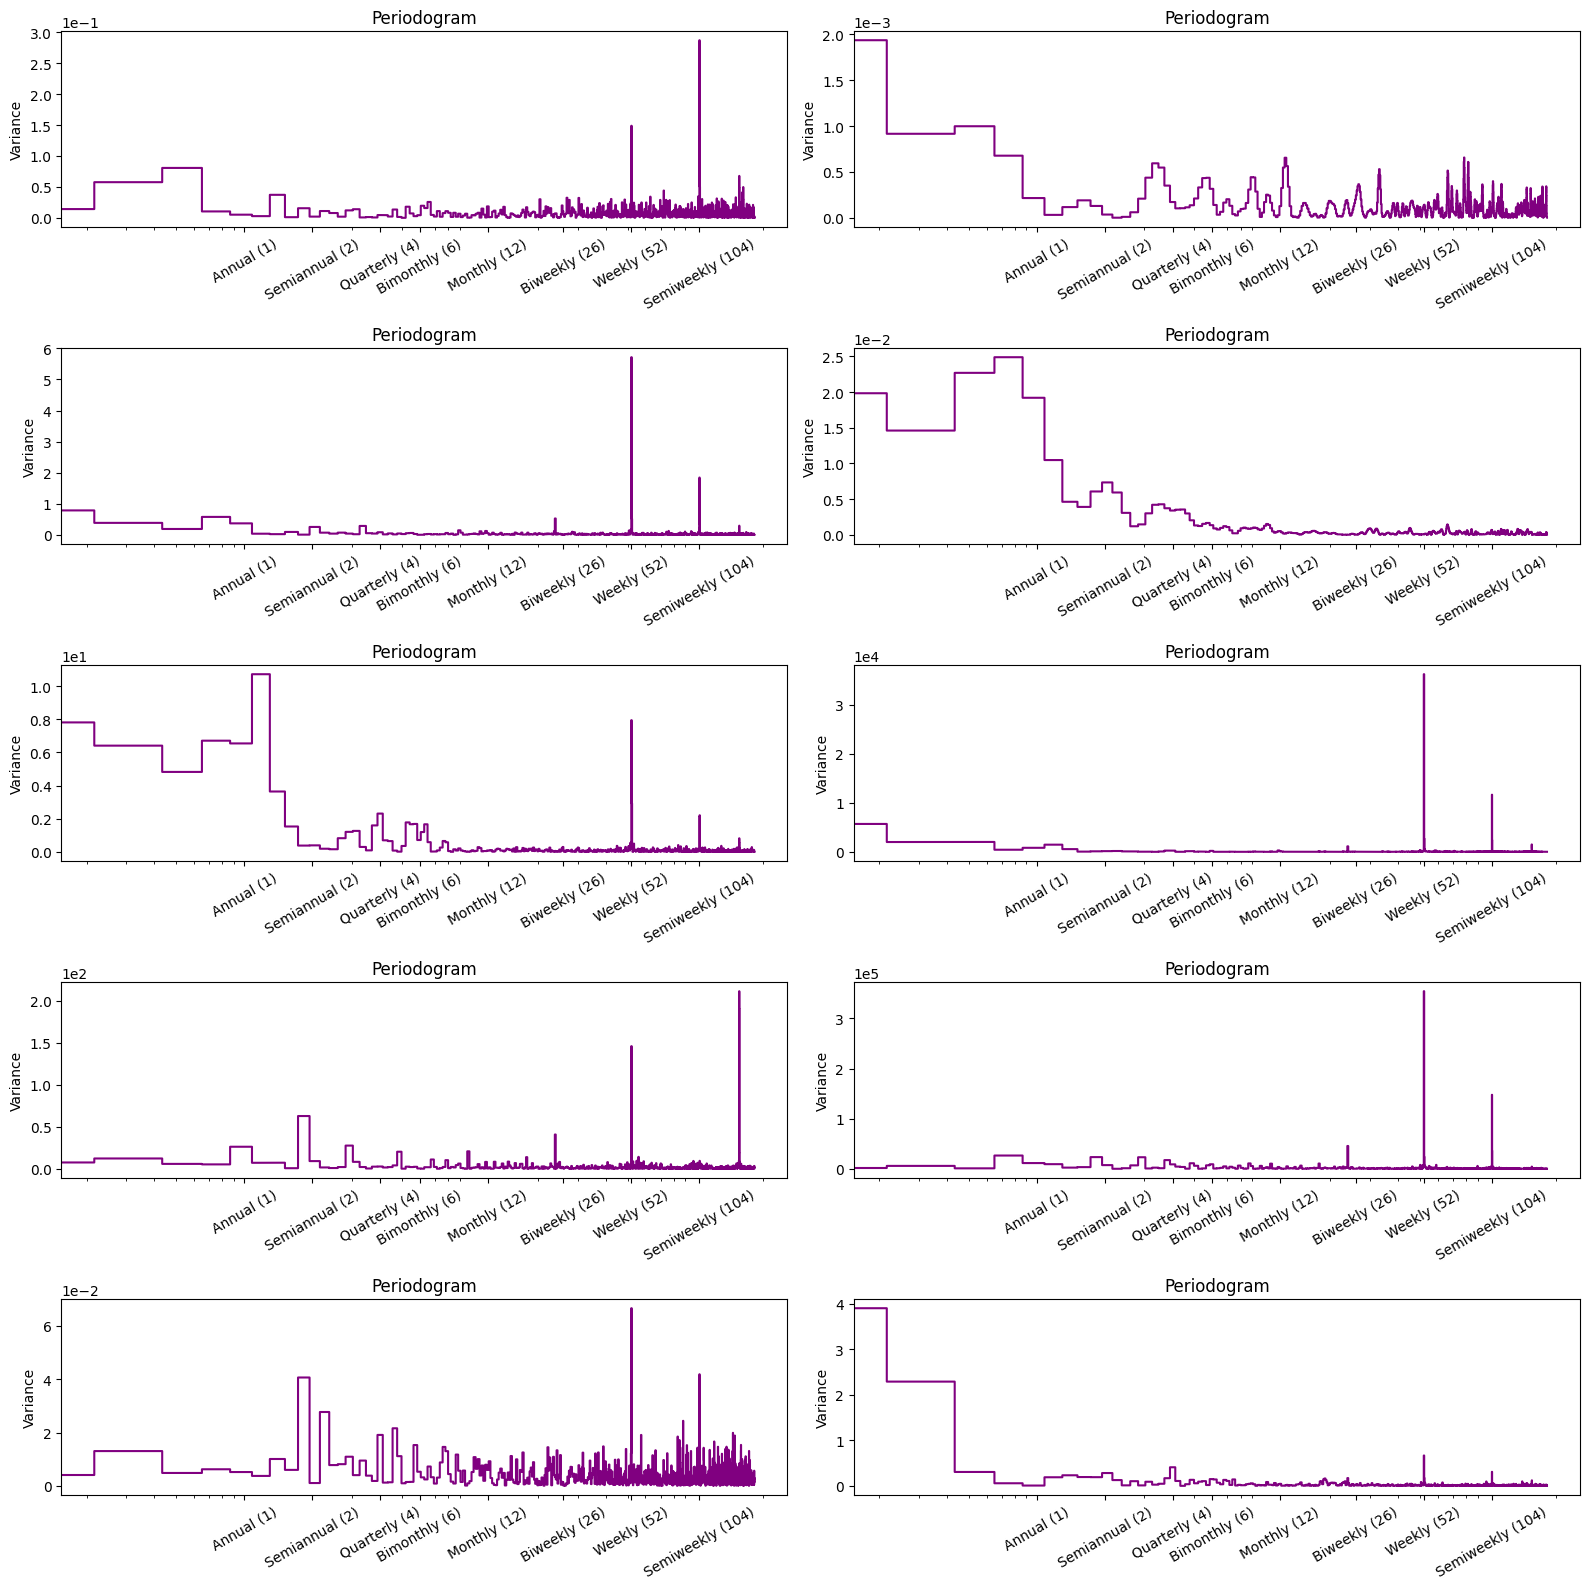

In [8]:
# plot periodogram for each store_family in subplots
fig, axes = plt.subplots(5, 2, figsize=(16, 16))
for i, ax in zip(['1_AUTOMOTIVE', '2_BABY CARE', '3_BEAUTY', '4_BOOKS', '5_CELEBRATION', '6_DAIRY', '7_EGGS', '8_GROCERY I', '9_HARDWARE', '10_HOME AND KITCHEN II'], axes.flatten()):
    plt.title(i)
    plot.plot_periodogram(df_train[df_train['store_family'] == i]['sales'], ax=ax)
plt.tight_layout()


- Conclusion: based on the periodograms above, use up to 26 Fourier features (52 pairs of sin/cos)
    - Some store_families have less
    - As a compromise, use 10 Fourier features

In [9]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for Annual seasonality

# since all store_families have the same length, we can get Fourier Features for one store_family and then concatenate them for all store_families

dp = DeterministicProcess(
    index=df_train[df_train['store_family'] == '1_AUTOMOTIVE']['date'],
    constant=True,               # dummy feature for bias (y-intercept)
    order=0,                     # trend (order 1 means linear)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=False,                   # drop terms to avoid collinearity
)

X_train = dp.in_sample()  # create features for dates in tunnel.index

In [10]:
print(f'{X_train.shape=}')
display(X_train.head())

X_train.shape=(1688, 21)


,const,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157


In [11]:
# join X_train and X_test to df_train and df_test
df_train = df_train.join(X_train)

display(df_train)


,family,store_nbr,date,sales,onpromotion,store_family,trend,year,month,day,...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE,0,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE,1,2013,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE,2,2013,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE,3,2013,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE,4,2013,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,SEAFOOD,54,2017-08-11,0.0,0,54_SEAFOOD,1683,2017,8,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3008012,SEAFOOD,54,2017-08-12,1.0,1,54_SEAFOOD,1684,2017,8,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3008013,SEAFOOD,54,2017-08-13,2.0,0,54_SEAFOOD,1685,2017,8,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3008014,SEAFOOD,54,2017-08-14,0.0,0,54_SEAFOOD,1686,2017,8,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- **Cyclicality Features**
    - Lag Features
    - Average of the last 4 weeks on the same day

In [12]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_8586/4075833985.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


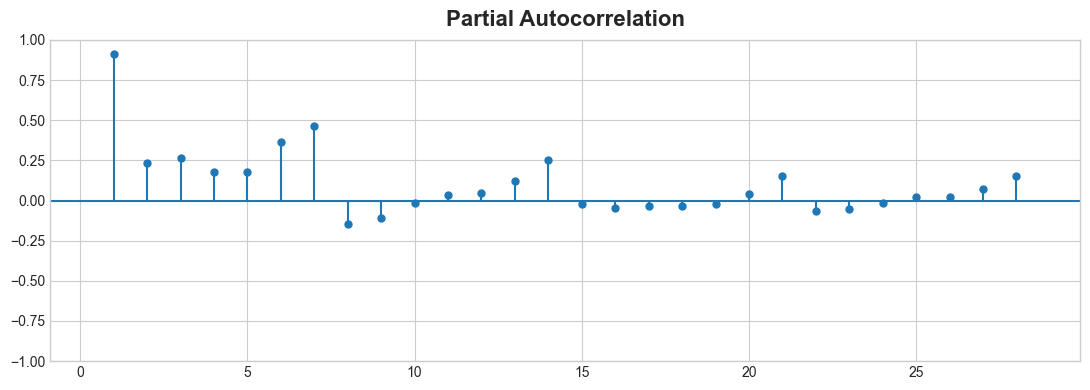

In [13]:
# _ = plot_lags(df_train.sales, lags=12, nrows=2)
_ = plot_pacf(df_train.sales, lags=28, method="ywm", zero=False)

- Conclusion: Looks like lag 1 - 7, 14, 21, 28 are significant. We will combine the results from the Mutual Information exercise to determine which lags to keep, and which ones to discard

In [14]:
# add lag features using the sales column
for i in tqdm(range(1, 29)): # 4 weeks
    df_train[f'sales_lag_{i}'] = df_train.groupby(['store_family'])['sales'].shift(i)    

print(f'{df_train.shape=}')
df_train.head()

100%|██████████| 28/28 [00:02<00:00,  9.71it/s]

df_train.shape=(3008016, 64)


,family,store_nbr,date,sales,onpromotion,store_family,trend,year,month,day,...,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_23,sales_lag_24,sales_lag_25,sales_lag_26,sales_lag_27,sales_lag_28
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE,0,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE,1,2013,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE,2,2013,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE,3,2013,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE,4,2013,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# average sales from past 4 weeks on the same day of the week
df_train['average_sales_last_4_weeks'] = df_train[[f'sales_lag_7', f'sales_lag_14', f'sales_lag_21', f'sales_lag_28']].mean(axis=1)

- **Add other exogenous features**
    - Store metadata
    - Holidays
    - Oil price

In [16]:
# join store data to df_train
df_train = df_train.merge(df_stores, on='store_nbr', how='left')

# join holiday data to df_train
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_train = df_train.merge(df_holidays, on='date', how='left')

# join transaction data to df_train
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_train = df_train.merge(df_transactions, on=['date', 'store_nbr'], how='left')
# add lag features using the transactions column
for i in tqdm(range(1, 29)): # 4 weeks
    df_train[f'transactions_lag_{i}'] = df_train.groupby(['store_family'])['transactions'].shift(i)

# join oil data to df_train
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_train = df_train.merge(df_oil, on='date', how='left')
# add lag features using oil column
for i in tqdm(range(1, 29)): # 4 weeks
    df_train[f'oil_lag_{i}'] = df_train.groupby(['store_family'])['dcoilwtico'].shift(i)


100%|██████████| 28/28 [00:02<00:00,  9.71it/s]


In [17]:
print(f'{df_train.shape=}')
df_train.head()



df_train.shape=(3061476, 132)


,family,store_nbr,date,sales,onpromotion,store_family,trend,year,month,day,...,oil_lag_19,oil_lag_20,oil_lag_21,oil_lag_22,oil_lag_23,oil_lag_24,oil_lag_25,oil_lag_26,oil_lag_27,oil_lag_28
0,AUTOMOTIVE,1,2013-01-01,0.0,0,1_AUTOMOTIVE,0,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUTOMOTIVE,1,2013-01-02,2.0,0,1_AUTOMOTIVE,1,2013,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUTOMOTIVE,1,2013-01-03,3.0,0,1_AUTOMOTIVE,2,2013,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUTOMOTIVE,1,2013-01-04,3.0,0,1_AUTOMOTIVE,3,2013,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUTOMOTIVE,1,2013-01-05,5.0,0,1_AUTOMOTIVE,4,2013,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Mutual Information
- Determine which features are most important for predicting the target

In [43]:
# Label encoding for categoricals
X = df_train[(df_train['year'] == 2016)].drop(columns=["date"])
y = X.pop("sales")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [44]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X.fillna(0), y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores



average_sales_last_4_weeks    1.742588
sales_lag_14                  1.576341
sales_lag_1                   1.496457
sales_lag_13                  1.387428
sales_lag_20                  1.359487
sales_lag_5                   1.337918
sales_lag_12                  1.311606
sales_lag_19                  1.289371
sales_lag_26                  1.280976
sales_lag_18                  1.262437
family                        1.168168
transactions                  0.134490
transactions_lag_1            0.093798
transactions_lag_8            0.085491
transactions_lag_6            0.082483
transactions_lag_21           0.082009
city                          0.080202
transactions_lag_10           0.079107
transactions_lag_20           0.078167
transactions_lag_17           0.076840
transactions_lag_27           0.074915
transactions_lag_26           0.073686
trend                         0.032619
oil_lag_20                    0.015759
oil_lag_26                    0.014931
oil_lag_16               

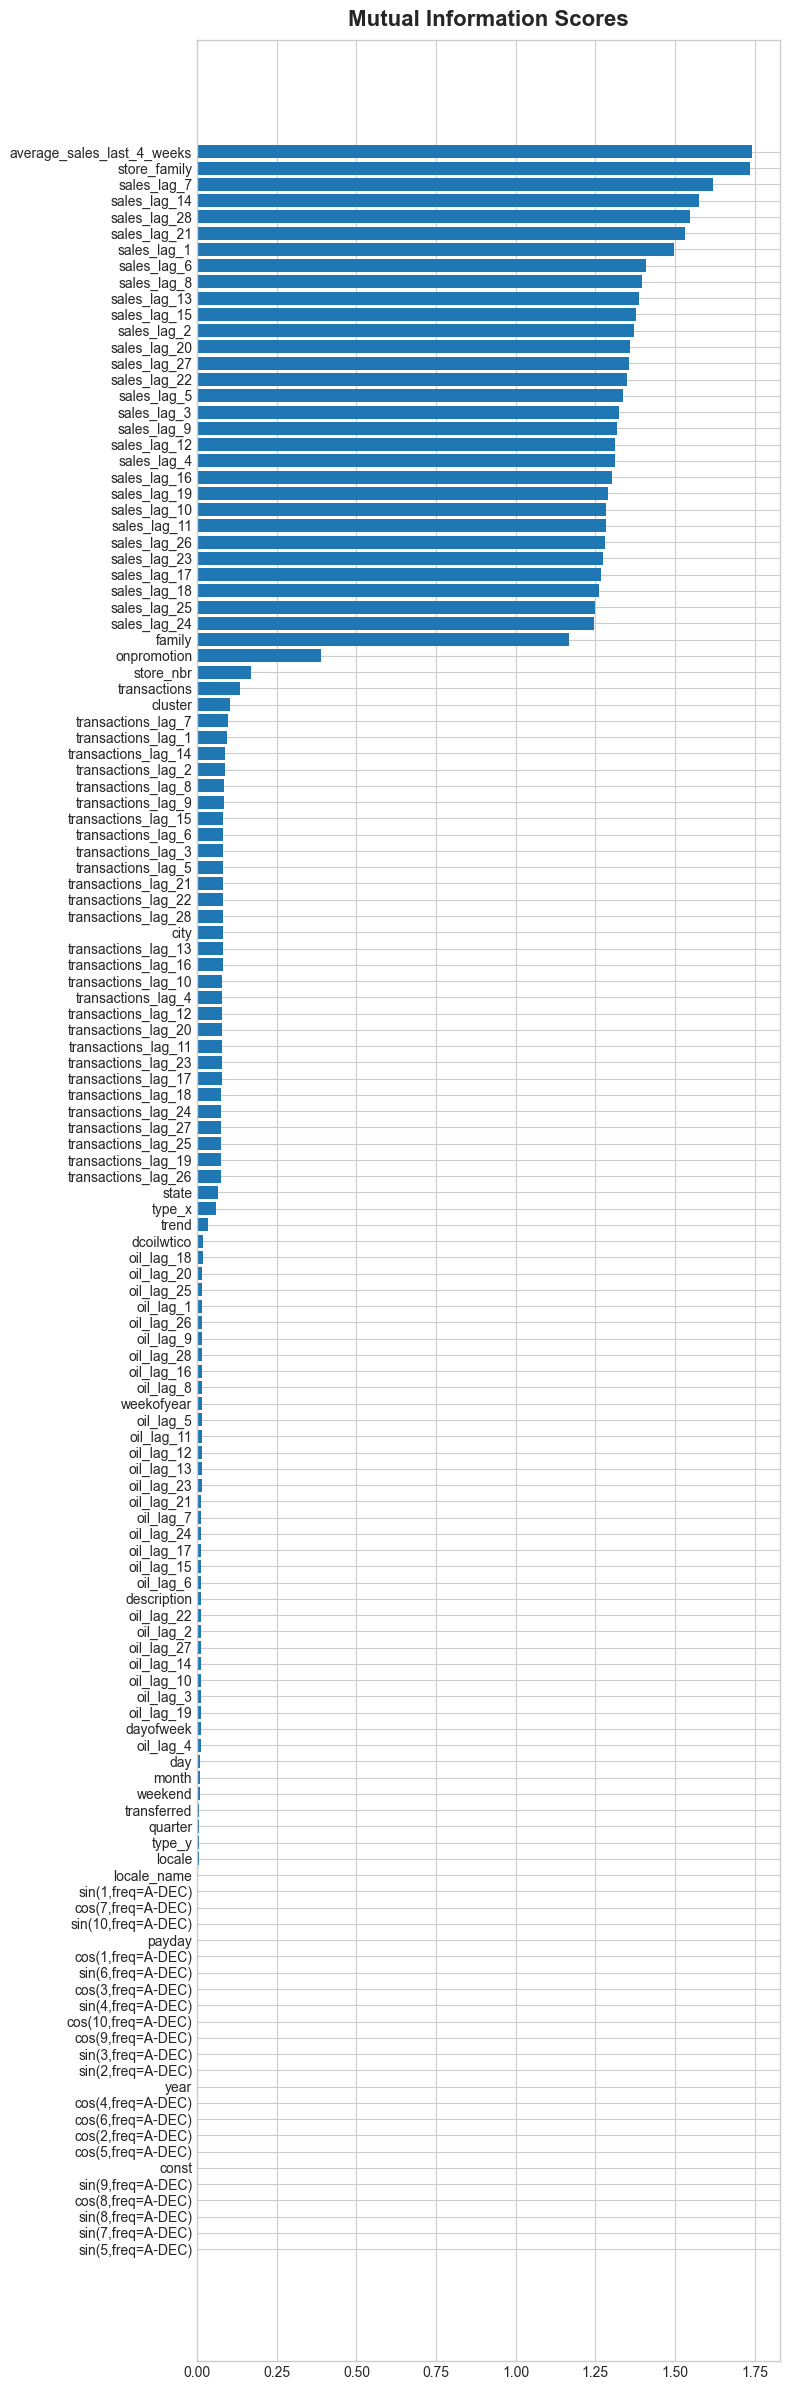

In [45]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 24))
plot_mi_scores(mi_scores)

# Summary
1. The most important features are the lagged sales, followed by the lagged transactions and lagged oil prices.
2. The store_family is the most important categorical feature, followed by onpromotion
3. The day of the week is the most important temporal feature
4. The average sales from the last 4 weeks is the most important feature that is not a lagged sales
5. Fourier features do not seem to be very important

**Note**: Sometimes, a feature may be very useful when interacting with other features, but less so on its own. Mutual information is not able to detect these interactions between features, as it is a univariate metric that only considers one feature at a time.

